频率分辨率: 2.5 Hz
找到 1 个数据文件

处理文件: REC3514_ch2.txt
读取到 512000 个数据点
数据统计: 长度=512000, 均值=-0.001365, 标准差=0.409500
分割为 250 个样本

处理样本 1/3
样本统计: 长度=2048, 均值=0.002789

前8个主要频率成分:
频率(Hz)	幅度
------------------------------
     2.5	    5.320889
     5.0	    4.245467
     7.5	    2.762176
    17.5	    1.653414
    15.0	    1.490172
    10.0	    1.326043
    20.0	    1.304766
图像已保存: D:\deskbook\科研\SQ_FFT_Results\REC3514_ch2.txt_sample_1.png


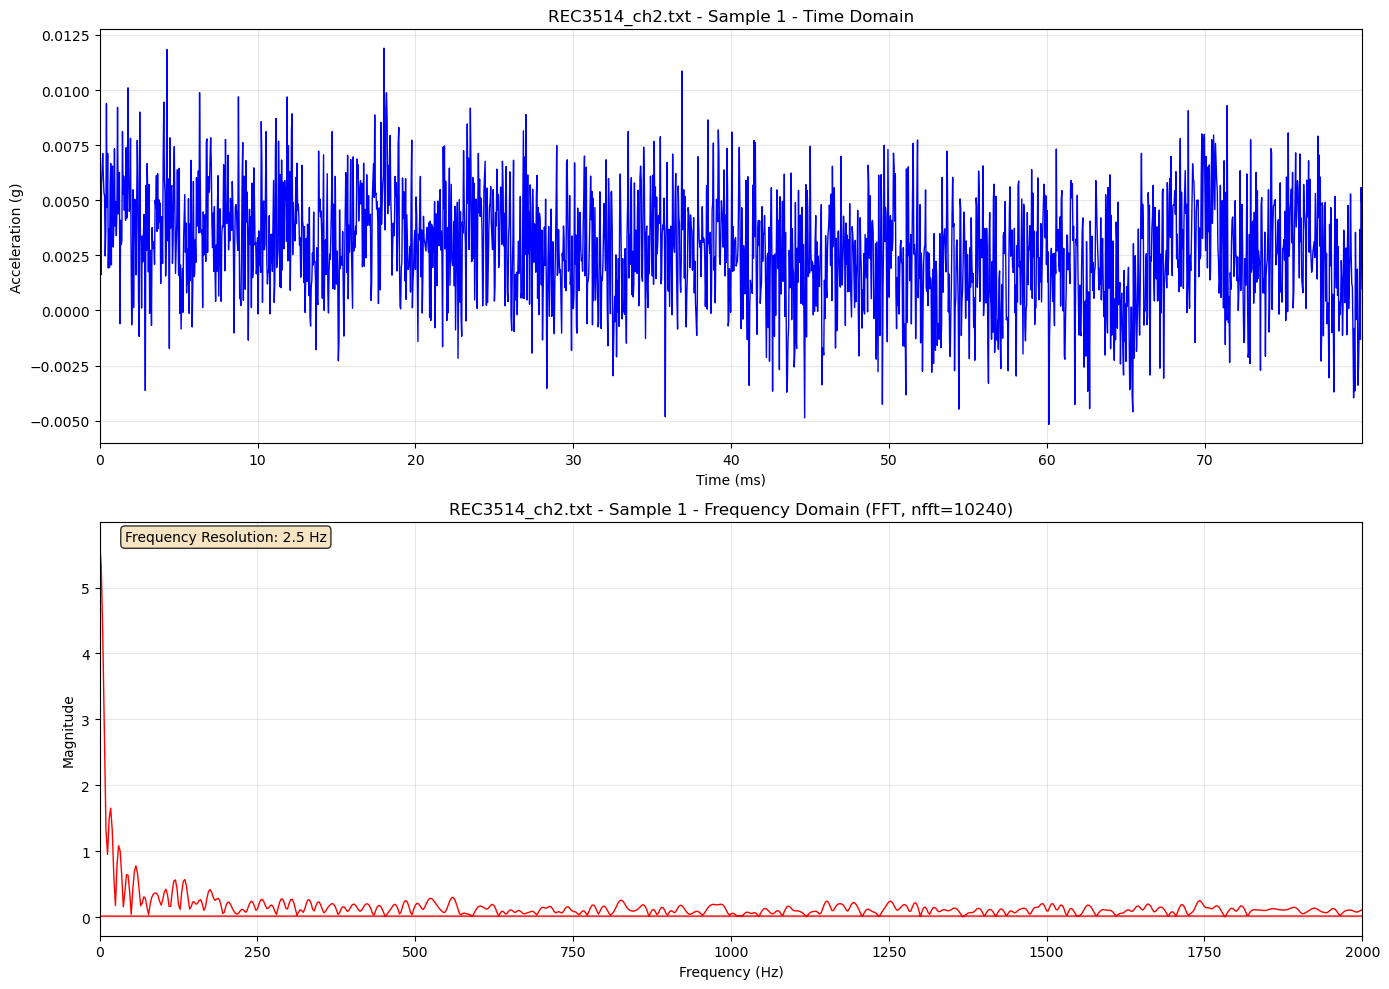


处理样本 2/3
样本统计: 长度=2048, 均值=0.001133

前8个主要频率成分:
频率(Hz)	幅度
------------------------------
     2.5	    2.135148
     5.0	    1.624969
    30.0	    1.056381
    32.5	    0.983186
     7.5	    0.921700
    27.5	    0.912420
    35.0	    0.741255
图像已保存: D:\deskbook\科研\SQ_FFT_Results\REC3514_ch2.txt_sample_2.png


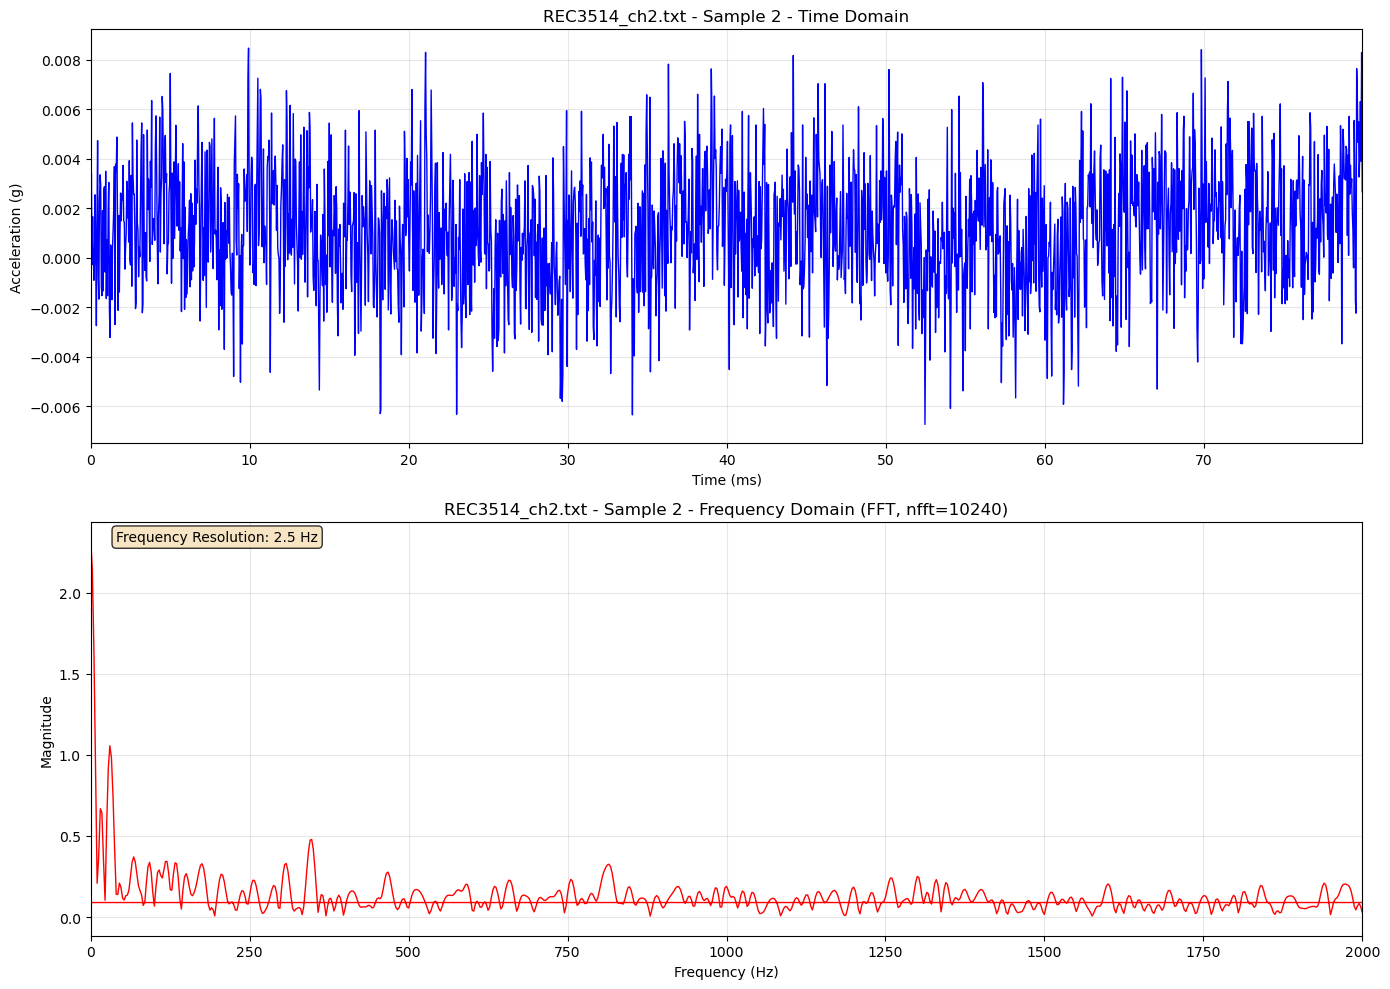


处理样本 3/3
样本统计: 长度=2048, 均值=0.002524

前8个主要频率成分:
频率(Hz)	幅度
------------------------------
     2.5	    4.841068
     5.0	    3.932134
     7.5	    2.641560
    10.0	    1.242593
    17.5	    1.233946
    20.0	    1.181237
    15.0	    0.847203
图像已保存: D:\deskbook\科研\SQ_FFT_Results\REC3514_ch2.txt_sample_3.png


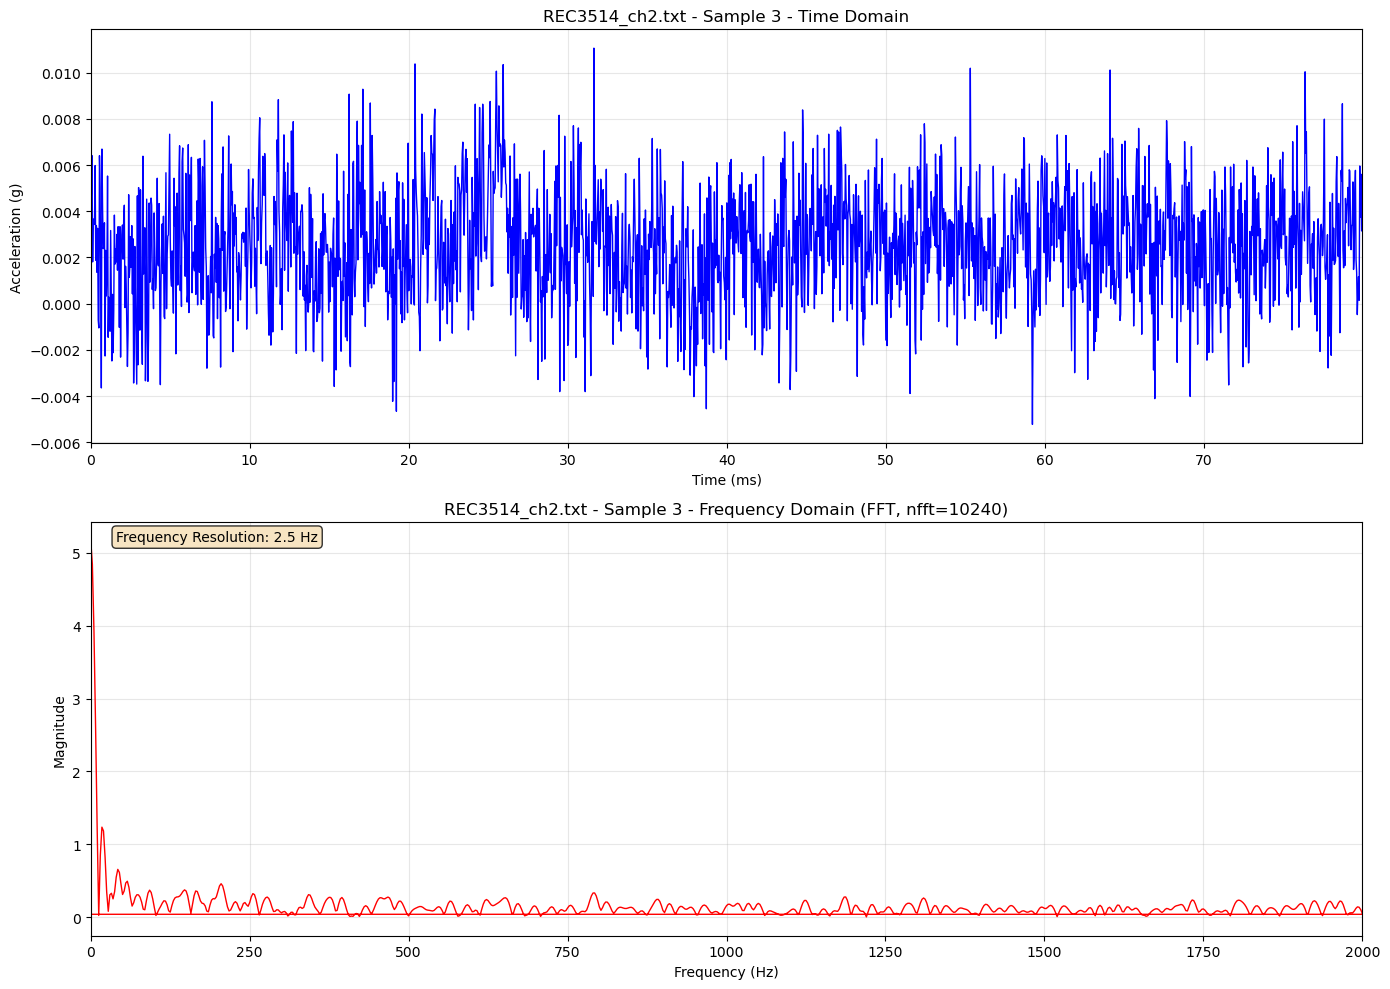

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft, fftfreq
import glob

# ===============================
# 参数设置（根据论文4.2.4节）
# ===============================
fs = 25600  # 采样频率 25.6 kHz
nfft = 10240  # FFT点数
segment_length = 2048  # 每个时域样本长度
df = fs / nfft  # 频率分辨率 = 2.5 Hz (论文中Δf=2.5 Hz)

print(f"频率分辨率: {df} Hz")

# ===============================
# 读取SQ轴承数据集（CoCo格式）
# ===============================
def read_coco_data(file_path):
    """读取CoCo数据采集系统导出的数据文件"""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()

        # 查找数据开始位置
        data_start = 0
        for i, line in enumerate(lines):
            if line.startswith('X:Time (Seconds)'):
                data_start = i + 1
                break

        if data_start == 0:
            print("未找到数据开始标记")
            return None

        # 读取数据
        time_data = []
        accel_data = []

        for line in lines[data_start:]:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                try:
                    time_val = float(parts[0])
                    accel_val = float(parts[1])
                    time_data.append(time_val)
                    accel_data.append(accel_val)
                except ValueError:
                    continue

        print(f"读取到 {len(accel_data)} 个数据点")
        return np.array(accel_data)

    except Exception as e:
        print(f"读取文件 {file_path} 时出错: {e}")
        return None

def segment_signal(signal, segment_length):
    """将信号分割为不重叠的段"""
    n_segments = len(signal) // segment_length
    segments = []
    for i in range(n_segments):
        start = i * segment_length
        end = start + segment_length
        segment = signal[start:end]
        segments.append(segment)
    return segments

# ===============================
# FFT变换函数
# ===============================
def compute_fft(segment, nfft):
    """计算信号的FFT"""
    # 对信号进行FFT
    fft_result = fft(segment, n=nfft)

    # 计算幅度谱（取绝对值）
    magnitude = np.abs(fft_result)

    # 取单边频谱（前nfft/2+1个点）
    magnitude_single = magnitude[:nfft//2 + 1]

    # 计算频率轴
    freqs = fftfreq(nfft, 1/fs)[:nfft//2 + 1]

    return freqs, magnitude_single

# ===============================
# 可视化函数
# ===============================
def plot_time_frequency_comparison(time_signal, freqs, fft_magnitude, title, save_path=None):
    """绘制时域信号和频域信号的对比图"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # 时域图
    time_axis = np.arange(len(time_signal)) / fs
    ax1.plot(time_axis * 1000, time_signal, 'b-', linewidth=1)  # 转换为毫秒
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Acceleration (g)')
    ax1.set_title(f'{title} - Time Domain')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, time_axis[-1] * 1000)

    # 频域图
    ax2.plot(freqs, fft_magnitude, 'r-', linewidth=1)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title(f'{title} - Frequency Domain (FFT, nfft={nfft})')
    ax2.grid(True, alpha=0.3)

    # 限制频率范围以便观察（0-2000 Hz）
    ax2.set_xlim(0, 2000)

    # 添加频率分辨率信息
    ax2.text(0.02, 0.98, f'Frequency Resolution: {df:.1f} Hz',
             transform=ax2.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图像已保存: {save_path}")

    plt.show()

    return fig

# ===============================
# 分析FFT结果
# ===============================
def analyze_fft_results(freqs, magnitude, top_n=10):
    """分析FFT结果，找出主要频率成分"""
    # 找出幅度最大的频率成分
    sorted_indices = np.argsort(magnitude)[::-1]

    print(f"\n前{top_n}个主要频率成分:")
    print("频率(Hz)\t幅度")
    print("-" * 30)

    for i in range(min(top_n, len(sorted_indices))):
        idx = sorted_indices[i]
        if freqs[idx] > 0:  # 只显示正频率
            print(f"{freqs[idx]:8.1f}\t{magnitude[idx]:12.6f}")

# ===============================
# 主处理流程
# ===============================
def process_sq_dataset(data_dir, output_dir):
    """处理SQ数据集"""
    os.makedirs(output_dir, exist_ok=True)

    # 查找所有的数据文件
    data_files = glob.glob(os.path.join(data_dir, "*.txt"))

    if not data_files:
        print(f"在目录 {data_dir} 中未找到数据文件")
        return

    print(f"找到 {len(data_files)} 个数据文件")

    # 处理每个文件
    for file_path in data_files[:2]:  # 只处理前2个文件作为示例
        filename = os.path.basename(file_path)
        print(f"\n处理文件: {filename}")

        # 读取数据
        data = read_coco_data(file_path)
        if data is None:
            continue

        print(f"数据统计: 长度={len(data)}, 均值={np.mean(data):.6f}, 标准差={np.std(data):.6f}")

        # 分割信号
        segments = segment_signal(data, segment_length)
        print(f"分割为 {len(segments)} 个样本")

        # 处理前3个样本
        for i, segment in enumerate(segments[:3]):
            print(f"\n处理样本 {i+1}/{min(3, len(segments))}")
            print(f"样本统计: 长度={len(segment)}, 均值={np.mean(segment):.6f}")

            # 计算FFT
            freqs, fft_magnitude = compute_fft(segment, nfft)

            # 分析FFT结果
            analyze_fft_results(freqs, fft_magnitude, top_n=8)

            # 绘制对比图
            title = f"{filename} - Sample {i+1}"
            save_path = os.path.join(output_dir, f"{filename}_sample_{i+1}.png")

            fig = plot_time_frequency_comparison(segment, freqs, fft_magnitude, title, save_path)

            # 关闭图形以释放内存
            plt.close(fig)

# ===============================
# 执行处理
# ===============================
if __name__ == "__main__":
    # 请根据您的实际文件路径修改
    data_directory = r"D:\deskbook\科研\数据集\SQ-dataset-with-variable-speed-for-fault-diagnosis-main\data"  # 替换为您的SQ数据集路径
    output_directory = r"D:\deskbook\科研\SQ_FFT_Results"

    process_sq_dataset(data_directory, output_directory)

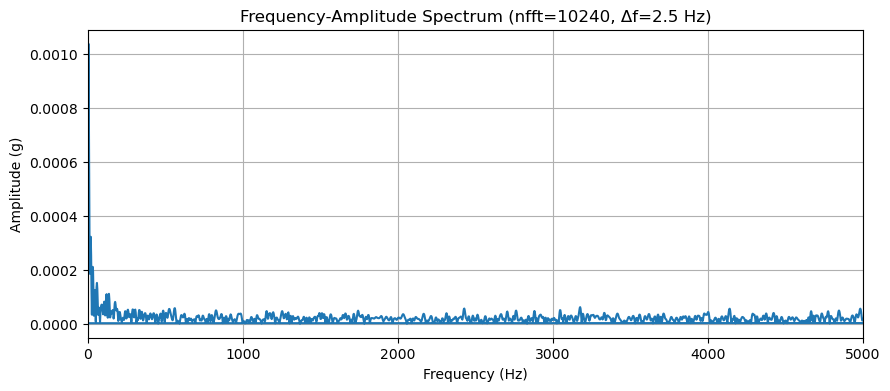

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取你提供的原始时域数据（假设已读为x_raw，shape=(460800,)，采样率25600 Hz）
x_raw = np.loadtxt(r"D:\deskbook\科研\数据集\SQ-dataset-with-variable-speed-for-fault-diagnosis-main\data\REC3514_ch2.txt", skiprows=16)[:, 1]  # 跳过前16行参数，取Y列（振动加速度g）

# 2. 时域样本切片：2048点/样本，无重叠
sample_len = 2048  # 论文切片长度
n_samples = len(x_raw) // sample_len  # 总样本数：460800//2048=225
x_samples = [x_raw[i*sample_len : (i+1)*sample_len] for i in range(n_samples)]

# 3. FFT参数（论文设定）
fs = 25600  # 采样率
nfft = 10240  # FFT点数
delta_f = fs / nfft  # 频率分辨率：2.5 Hz

# 4. 对第一个样本做FFT（示例）
x_sample = x_samples[0]  # 取第一个2048点样本
x_padded = np.pad(x_sample, (0, nfft - sample_len), mode='constant')  # 补零到10240点
X_fft = np.fft.fft(x_padded, n=nfft)  # 执行FFT

# 5. 计算单侧边谱（幅值）
freq = np.fft.fftfreq(nfft, 1/fs)[:nfft//2 + 1]  # 正频率轴：0~12800 Hz，共5121个点
X_mag = np.abs(X_fft)[:nfft//2 + 1]  # 复数模值（幅值）
# 幅值修正（直流和奈奎斯特频率除以nfft，其余除以nfft/2）
X_mag[0] = X_mag[0] / nfft
X_mag[-1] = X_mag[-1] / nfft
X_mag[1:-1] = X_mag[1:-1] / (nfft / 2)

# 6. 绘制“频率-幅值”谱（与论文可视化一致）
plt.figure(figsize=(10, 4))
plt.plot(freq, X_mag)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (g)')
plt.title('Frequency-Amplitude Spectrum (nfft=10240, Δf=2.5 Hz)')
plt.xlim(0, 5000)  # 通常关注低频段（故障特征频率多在0~5000 Hz）
plt.grid(True)
plt.show()